<h1 style="text-align: center;"> Final Project </h1>

<h2 style="text-align: center;">  Pandemic Simulator </h2>
<h3 style="text-align: center;">Team members: Matt Mitchell, Nick Vino, and Logan Jolicoeur </h3>

# Section I
## Introduction
In this notebook, we'll develop a model of a pandemic as it directly spreads in a susceptible population, and explore the effectiveness of interventions such as vaccination and quarantining . Epidemiologic modeling is important for understanding disease spread and developing plans to control the spread. In Section II, we establish a strong foundation by building the simpliest SI model to discover the underlying ordinary differential equations that dictate the rules for the system and an inuitive sense for how to extend the model to capture more nuances which correspond to a more realistic model.

According to 2022 census records, the city of Banner Elk in North Carolina has a population of approximately 1,000 people. Banner Elk will be the center of our attention as we simulate the spread of an infection in the city. To simplify our study we assume the town will have a fixed population, i.e., no vital processes. We introduce well-known models of infectious disease, the SI model, the SIR (Kermack-McKendrick) model, SIS model, SIRS model, SIRV model and use them to explain the progression of the disease over the course of 2,000 days.



# Section II
## Implementation
The following models were produced with the Epidemics on Networks (EoN) package for python

Citation: [Journal of Open Source Software publication](https://doi.org/10.21105/joss.01731)

The following packages are necessary for this notebook:

In [ ]:
import EoN
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from PIL import Image
from IPython.display import HTML

## SI Model

Initially, we consider a model with no recovery rate, a person is considered to be either susceptible or infected. A real life example of a SI disease is the herpesvirus family of viruses which characteristically establishes latent infection within specific tissues [[1]](https://www.ncbi.nlm.nih.gov/books/NBK8157/). The interaction between the two classes of population results in a flow from susceptible to infected over time. We can write this as the following rates of change for S and I respectively:

$\frac{dS}{dt} = -\beta SI$

$\frac{dI}{dt} = \beta SI$

This nonlinear system of differential equation can be solved assuming the population remains constant by adding the two equations. We arrive at $\frac{dS}{dt} + \frac{dI}{dt} = 0$ which can be integrated giving us $S(t) + I(t) = S(0) + I(0)$. The initial population is $N$ so we write $S(t) + I(t) = N$ to allow us to replace $S$ in the rates above with $N - I$. Our new equation is as follows

$\frac{dI}{dt} = \beta (N-I)I$.

If $I(0) > 0$, then the equilibrium $N$ will be approached as $t$ approaches infinity. Simply put the SI model predicts that everyone will become infected as long as there is an initial infected population.

Furthermore, we choose to investigate the value $R_0$ which is defined as the total number of new infected caused by each infected individual, on average.

$R_0 = \beta \cdot \langle k \rangle \cdot d = 0.0015 \cdot 5 \cdot 2000 = 15$

For a population of 1000 we expect an infected person to cause 15 new infections on average [[2]](https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf).

The graph produced below illustrates how fast an outbreak can occur once enough fuel is provided. There are ~10% infected 400 days in to the simulation, then the infection skyrockets to 50% in another 400 days. We observe in the span of 1600 days from the start a total infection of the population.

In [ ]:
N=1000
rho = 0.01      #intial infected
kave = 5
gamma = 0       #recovery rate
beta = 0.0015    #transmision rate

S0 = (1-rho)*N
I0 = rho*N
SI0 = (1-rho)*kave*rho*N
SS0 = (1-rho)*kave*(1-rho)*N
t, S, I = EoN.SIS_homogeneous_pairwise(S0, I0, SI0, SS0, kave, beta, gamma, tmax=2000)

plt.plot(t, S, label = 'S')
plt.plot(t, I, label = 'I')
plt.xlabel('$t$')
plt.ylabel('Population')
plt.legend()
plt.show()

## SIR Model

The SIR model introduces another compartment for the population to be partitioned into after recovering from an infection. It should be noted that individuals recover with permanent immunity. This type of model is relevant for studying diseases such as measles, mumps, and smallpox.

$\frac{dS}{dt} = -\beta SI$

$\frac{dI}{dt} = \beta SI - \gamma I$

$\frac{dR}{dt} = \gamma I$

Initially, $S \approx N$ and $I < N$ we can rewrite the rate of infection as $\frac{dI}{dt} = I(\beta N - \gamma)$. Solving the differential equation gives us $I(t) = I(0)e^{\beta N - \gamma}$. We are interested in a growing exponential, an epidemic, which occurs when $\beta - \gamma > 0$ or equivalently $\beta / \gamma > 1$. 

The basic reproductive ratio can now be solved as follows $R_0 = \beta /\gamma = \frac{0.65}{0.2} = 3.25$. 

In this closed system, an epidemic will die out because there is not enough susceptible individuals to sustain the disease after the exponential outbreak. In about 4 days the epidemic infects 70% of the population but rapidly drops to 0 by day 30.

In [ ]:
N = 1000            #population
rho = 0.01          #initial infected
kave = 5.5            #average degree
gamma = 0.2        #recovery rate
beta = 0.65         #transmission rate

phiS0 = 1-rho
def psi(x):
    return (1-rho)* np.exp(-kave*(1-x))
def psiPrime(x):
    return (1-rho)*kave*np.exp(-kave*(1-x))

t, S, I, R = EoN.EBCM(N, psi, psiPrime, beta, gamma, phiS0, tmax = 50)
plt.plot(t, S, label = 'S')
plt.plot(t, I, label = 'I')
plt.plot(t, R, label = 'R')
plt.xlabel('$t$')
plt.ylabel('Population')
plt.title("SIR: 5 day recovery")
plt.legend()
plt.show()

## SIS Model

In the SIS model, recovery does not give immunity to the disease since individuals move from the susceptible class to the infective class and then back to the susceptible class upon recovery. This type of model is most appropriate for bacterial agent diseases such as streptococcal sore throat, meningitis and venereal diseases, and for protozoan agent diseases such as malaria and sleeping sickness [[3]](https://www.stat.cmu.edu/~kass/covid/Hethcote1989ThreeBasicModels.pdf). As a natural extension from the SI model, the SIS model simply needs the addition of a rate of change from infected to susceptible as follows

$\frac{dS}{dt} = \gamma I- \beta SI$

$\frac{dI}{dt} = \beta SI - \gamma I$

Using the same substitution in the SI model above, we arrive at the equation

$\frac{dI}{dt} = I(\beta N - \gamma) - \beta I^2$.

Assuming there is an positive initial infective fraction, when $\beta / \gamma > 1$, it stands to reason, that ratio approaches a constant endemic value; otherwise, the disease will die out. The graph below shows an outbreak approaching 40% infected population and 60% susceptible population at steady state. For $R_0 = 2.5$, the infected fraction at equilibrium is $\zeta = 1 - (\frac{1}{2.5}) = 40\%$ as expected.

In [ ]:
N = 1000
rho = 0.01
kave = 6

gamma = 0.013
beta = 0.004

S0 = 990
I0 = 10
SI0 = (1-rho)*kave*rho*N
SS0 = (1-rho)*kave*(1-rho)*N
t, S, I = EoN.SIS_homogeneous_pairwise(S0, I0, SI0, SS0, kave, beta, gamma, tmax=2000)
plt.plot(t, S, label = 'S')
plt.plot(t, I, label = 'I')
plt.xlabel('$t$')
plt.ylabel('Population')
plt.legend()
plt.show()

## SIRS Model

Airborne diseases like seasonal influenza. Allows recovered individuals to return to a susceptible state.

$\frac{dS}{dt} = -\beta SI + \xi R$

$\frac{dI}{dt} = \beta SI - \gamma I$

$\frac{dR}{dt} = \gamma I - \xi R$

$R_0 = \beta / (\gamma + \xi)= 0.7 / (0.2 + 0.05) = 2.8$

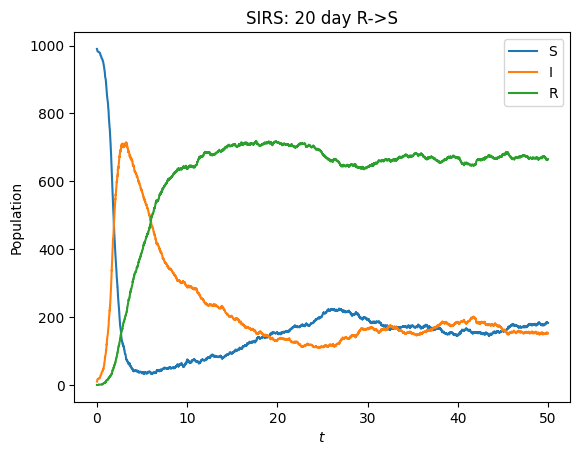

In [184]:
N = 1000
kave = 5    #expected number of partners
G = nx.fast_gnp_random_graph(N, kave/(N-1))

H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
H.add_edge('I', 'R', rate = 0.2)   #Recovery rate
H.add_edge('R', 'S', rate = 0.05)   #Recovered -> Susceptible

J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
J.add_edge(('I', 'S'), ('I', 'I'), rate = 0.7)  #Infect rate

IC = defaultdict(lambda: 'S')
for node in range(10):
    IC[node] = 'I'

return_statuses = ('S', 'I', 'R')

t, S, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 50)

plt.plot(t, S, label = 'S')
plt.plot(t, I, label = 'I')
plt.plot(t, R, label = 'R')
plt.xlabel('$t$')
plt.ylabel('Population')
plt.title("SIRS: 20 day R->S")
plt.legend()

## SIRV Model

In [ ]:
G = nx.grid_2d_graph(32,32) #each node is (u,v) where 0<=u,v<=32    32x32 = 1024 population
#we'll initially infect those near the middle
initial_infections = [(u,v) for (u,v) in G if 14<u<18 and 14<v<18] # 3x3 = 9 initial infected
H = nx.DiGraph() #the spontaneous transitions
H.add_edge('Sus', 'Vac', rate = 0.0003)
H.add_edge('Inf', 'Rec', rate = 0.0025)
J = nx.DiGraph() #the induced transitions
J.add_edge(('Inf', 'Sus'), ('Inf', 'Inf'), rate = 0.01)

IC = defaultdict(lambda:'Sus')
for node in initial_infections:
    IC[node] = 'Inf'
    
return_statuses = ['Sus', 'Inf', 'Rec', 'Vac']

color_dict = {'Sus': '#E69A00','Inf':'#ff2000', 'Rec':'#CD9AB3','Vac': '#03254c'}
pos = {node:node for node in G}
tex = False
sim_kwargs = {'color_dict':color_dict, 'pos':pos, 'tex':tex}

sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax=2000, return_full_data=True, sim_kwargs=sim_kwargs)

times, D = sim.summary()

newD = {'Sus+Vac':D['Sus']+D['Vac'], 'Inf+Rec' : D['Inf'] + D['Rec']}

new_timeseries = (times, newD)
sim.add_timeseries(new_timeseries, label = 'Simulation', color_dict={'Sus+Vac':'#E69A00', 'Inf+Rec':'#CD9AB3'})

sim.display(time=1, node_size = 4, ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']])

ani=sim.animate(ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']], node_size = 4)
ani.save('SIRV_animate.gif', writer="pillow", dpi=100)

In [ ]:
G = nx.grid_2d_graph(32,32) #each node is (u,v) where 0<=u,v<=32
#we'll initially infect those near the middle
initial_infections = [(u,v) for (u,v) in G if 14<u<18 and 14<v<18]
H = nx.DiGraph() #the spontaneous transitions
H.add_edge('Sus', 'Vac', rate = 0.0005)
H.add_edge('Inf', 'Rec', rate = 0.0025)
J = nx.DiGraph() #the induced transitions
J.add_edge(('Inf', 'Sus'), ('Inf', 'Inf'), rate = 0.01)

IC = defaultdict(lambda:'Sus')
for node in initial_infections:
    IC[node] = 'Inf'
    
return_statuses = ['Sus', 'Inf', 'Rec', 'Vac']

color_dict = {'Sus': '#E69A00','Inf':'#ff2000', 'Rec':'#CD9AB3','Vac': '#03254c'}
pos = {node:node for node in G}
tex = False
sim_kwargs = {'color_dict':color_dict, 'pos':pos, 'tex':tex}

sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax=2000, return_full_data=True, sim_kwargs=sim_kwargs)

times, D = sim.summary()

newD = {'Sus+Vac':D['Sus']+D['Vac'], 'Inf+Rec' : D['Inf'] + D['Rec']}

new_timeseries = (times, newD)
sim.add_timeseries(new_timeseries, label = 'Simulation', color_dict={'Sus+Vac':'#E69A00', 'Inf+Rec':'#CD9AB3'})

sim.display(time=1, node_size = 4, ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']])

ani2=sim.animate(ts_plots=[['Inf'], ['Sus+Vac', 'Inf+Rec']], node_size = 4)
ani2.save('SIRV_animate.gif', writer="pillow", dpi=100)

In [ ]:

HTML(ani.to_jshtml())

In [ ]:
HTML(ani2.to_jshtml())